## Set up

In [12]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it 
!test ! -e ds-assets && git clone https://github.com/IndraniMandal/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/" 
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


In [13]:
# preamble to be able to run notebooks in Jupyter and Colab
try:
    from google.colab import drive
    import sys
    
    drive.mount('/content/drive')
    notes_home = "/content/drive/My Drive/CSC310/notes/"
    user_home = "/content/drive/My Drive/"
    
    sys.path.insert(1,notes_home) # let the notebook access the notes folder

except ModuleNotFoundError:
    notes_home = "" # running native Jupyter environment -- notes home is the same as the notebook
    user_home = ""  # under Jupyter we assume the user directory is the same as the notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# set up
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
# model evaluation routines
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from assets.confint import classification_confint

In [15]:
%matplotlib inline

import os
os.getcwd()

'/content'

## Getting data

Originally, I struggled to understand the dataset in my analysis. The original question I'd hoped to answer is if maching learning could categorize each animal. After working with the data a little more, I ralized the dataset grouped similar animals together rather than trying to identify each unique animal. With this in mind, the new target label I used was 'type' and the rest of the dataset follows this format.

Data set name: Zoo

In [16]:
df = pd.read_csv(notes_home+"assets/zoo.data")

In [17]:
df.columns=['Animal' , 'hair', 'feathers' , 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'type']

columns:

Animal - (string) one out of 100 different animals

hair - (boolean) 

feathers - (boolean)

eggs - (boolean)

milk - (boolean)

airborne - (boolean)

aquatic - (boolean)

predator - (boolean)

toothed - (boolean)

backbone - (boolean)

breathes - (boolean)

venomous - (boolean)

fins - (boolean)

legs - (integer) describes how many legs the animal has. The numbers will be 0,2,4,5,6, or 8

tail - (boolean)

domestic - (boolean)

catsize - (boolean)

type - (integer) A range from 1-7, similar animals are grouped together. This is the target value and is described more in depth below

1 -- (41) aardvark, antelope, bear, boar, buffalo, calf, cavy, cheetah, deer, dolphin, elephant, fruitbat, giraffe, girl, goat, gorilla, hamster, hare, leopard, lion, lynx, mink, mole, mongoose, opossum, oryx, platypus, polecat, pony, porpoise, puma, pussycat, raccoon, reindeer, seal, sealion, squirrel, vampire, vole, wallaby,wolf

2 -- (20) chicken, crow, dove, duck, flamingo, gull, hawk, kiwi, lark, ostrich, parakeet, penguin, pheasant, rhea, skimmer, skua, sparrow, swan, vulture, wren

3 -- (5) pitviper, seasnake, slowworm, tortoise, tuatara

4 -- (13) bass, carp, catfish, chub, dogfish, haddock, herring, pike, piranha, seahorse, sole, stingray, tuna

5 -- (4) frog, frog, newt, toad

6 -- (8) flea, gnat, honeybee, housefly, ladybird, moth, termite, wasp

7 -- (10) clam, crab, crayfish, lobster, octopus, scorpion, seawasp, slug, starfish, worm

In [18]:
df

,Animal,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
1,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
2,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
3,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
4,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
96,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
97,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
98,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


Rows: 100

Columns: 18

Target label: type

## Analyzing Data

In [19]:
df.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,0.420000,0.200000,0.590000,0.400000,0.240000,0.360000,0.55,0.600000,0.820000,0.79000,0.08000,0.170000,2.830000,0.750000,0.130000,0.43000,2.850000
std,0.496045,0.402015,0.494311,0.492366,0.429235,0.482418,0.50,0.492366,0.386123,0.40936,0.27266,0.377525,2.040276,0.435194,0.337998,0.49757,2.105188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,1.000000,1.00000,0.00000,0.000000,2.000000,0.750000,0.000000,0.00000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00,1.000000,1.000000,1.00000,0.00000,0.000000,3.000000,1.000000,0.000000,0.00000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.00,1.000000,1.000000,1.00000,0.00000,0.000000,4.000000,1.000000,0.000000,1.00000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,1.00000,1.00000,1.000000,8.000000,1.000000,1.000000,1.00000,7.000000


Numeric/Categorical: Categorical

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b4a950f50>,
      dtype=object)

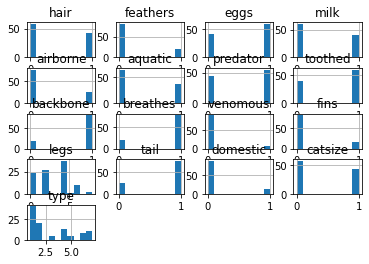

In [20]:
df.hist()

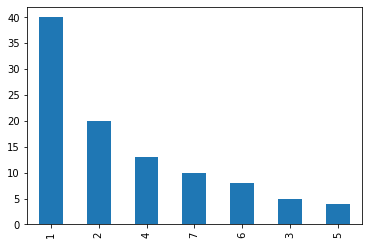

In [21]:
df['type'].value_counts().plot(kind='bar')

The question I hope to answer is: how well can machine learning categorize various animals?

## KNN Model

I will compare the KNN model with the classification MLP model.

In [30]:
from sklearn.model_selection import cross_val_score

# get data
X  = df.drop(['Animal', 'type'],axis=1)
y = df['type']

# set up the model with k=3
model = KNeighborsClassifier(n_neighbors=3)

# do train-test
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2)
model.fit(train_X, train_y)
predict_y = model.predict(test_X)
print("Train-Test Accuracy: {:3.2f}".format(accuracy_score(test_y, predict_y)))

# do the 5-fold cross validation
scores = cross_val_score(model, X, y, cv=5)
print("Fold Accuracies: {}".format(scores))
print("XV Accuracy: {:3.2f}".format(scores.mean()))

Train-Test Accuracy: 0.90
Fold Accuracies: [1.   0.85 0.9  0.95 0.95]
XV Accuracy: 0.93


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


### Confidence Interval

In [32]:
actual_y = df['type']

# KNN
model = KNeighborsClassifier()

# grid search
param_grid = {'n_neighbors': list(range(1,51))}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X, actual_y)
print("Grid Search: best parameters: {}".format(grid.best_params_))

# accuracy of best model with confidence interval
best_model = grid.best_estimator_
predict_y = best_model.predict(X)
acc = accuracy_score(actual_y, predict_y)
lb,ub = classification_confint(acc,X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f},{:3.2f})".format(acc,lb,ub))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Grid Search: best parameters: {'n_neighbors': 1}
Accuracy: 1.00 (1.00,1.00)


### Confusion Matrix

In [34]:
# build the confusion matrix
labels = [1, 2, 3, 4, 5, 6, 7]
cm = confusion_matrix(actual_y, predict_y, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df))

Confusion Matrix:
    1   2  3   4  5  6   7
1  40   0  0   0  0  0   0
2   0  20  0   0  0  0   0
3   0   0  5   0  0  0   0
4   0   0  0  13  0  0   0
5   0   0  0   0  4  0   0
6   0   0  0   0  0  8   0
7   0   0  0   0  0  0  10


## MLP Model

In [35]:
X  = df.drop(['Animal', 'type'],axis=1)
y = df['type']
print("Shape: {}".format(X.shape))

Shape: (100, 16)


In [36]:
# neural network
model = MLPClassifier(hidden_layer_sizes=(60,), max_iter=10000, random_state=1)

# train and test the model
model.fit(X, y)
predict_y = model.predict(X)
acc = accuracy_score(y, predict_y)
lb, ub = classification_confint(acc, X.shape[0])
print("Accuracy: {:3.2f} ({:3.2f}, {:3.2f})".format(acc, lb, ub))

Accuracy: 1.00 (1.00, 1.00)


### Confidence Interval

In [40]:
# build the confusion matrix
labels = [1, 2, 3, 4, 5, 6, 7]
cm = confusion_matrix(actual_y, predict_y, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix:\n{}".format(cm_df))

Confusion Matrix:
    1   2  3   4  5  6   7
1  40   0  0   0  0  0   0
2   0  20  0   0  0  0   0
3   0   0  5   0  0  0   0
4   0   0  0  13  0  0   0
5   0   0  0   0  4  0   0
6   0   0  0   0  0  8   0
7   0   0  0   0  0  0  10


## Analysis

From the different models, the data has a fairly high accuracy with either model, but the MLP model preforms much better.